In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [168]:
def get_digit_from_file(file, digits):
    all_instances = np.genfromtxt(file, delimiter=',')

    digit_mask = all_instances[:, 0] == digits[0]

    for digit in digits[1:]:
        digit_mask = digit_mask | (all_instances[:, 0] == digit)

    return all_instances[digit_mask]


data_dir = '../data/'
training_fn = data_dir + 'DigitsTraining.csv'
testing_fn = data_dir + 'DigitsTesting.csv'

udid_digit = 6
other_digit = 1

training_data = get_digit_from_file(training_fn, [udid_digit, other_digit])
testing_data = get_digit_from_file(testing_fn, [udid_digit, other_digit])

In [187]:
def get_digit_intensity(digit_instances):
    return np.average(digit_instances, axis=1)

def get_digit_symetry(digit_instances):
    digit_img = np.reshape(digit_instances, (-1, 16, 16))
    
    ver_symmetry = np.abs(digit_img - np.flip(digit_img, axis=1)).mean(axis=(1,2))
    hor_symmetry = np.abs(digit_img - np.flip(digit_img, axis=2)).mean(axis=(1,2))
 
    total_symmetry = (ver_symmetry + hor_symmetry) / 2

    return total_symmetry

def get_six_template(digit_instances, labels):
    digit_instances = digit_instances[np.where(labels == 6)]
    digit_img = np.reshape(digit_instances, (-1, 16, 16))
    six_template = np.mean(digit_img, axis=0)

    return np.expand_dims(six_template, 0)

def get_six_matching(digit_instances, labels):
    six_template = get_six_template(digit_instances, labels)

    digit_img = np.reshape(digit_instances, (-1, 16, 16))

    six_matching = np.abs((six_template - digit_img)).mean(axis=(1,2))

    return six_matching

def get_features_labels(data, udid_digit, other_digit, third_feat=False):
    digits = data[:, 1:]
    features = [get_digit_intensity(digits), get_digit_symetry(digits)]

    if third_feat:
        features.append(get_six_matching(digits, data[:, 0]))

    features = np.array(features).T

    labels = data[:, 0].copy()
    labels[labels == other_digit] = -1
    labels[labels == udid_digit] = 1

    return features, labels

In [189]:
training_features, training_labels = get_features_labels(training_data, udid_digit, other_digit)
testing_features, testing_labels = get_features_labels(testing_data, udid_digit, other_digit)

print('training_features.shape', training_features.shape)
print('training_labels.shape', training_labels.shape, '\n')

print('testing_features.shape', testing_features.shape)
print('testing_labels.shape', testing_labels.shape)

training_features.shape (1669, 2)
training_labels.shape (1669,) 

testing_features.shape (434, 2)
testing_labels.shape (434,)


In [148]:
def perceptron_learning_algorithm(X, y, X_test, y_test, max_iterations=200, save_pocket=False):
    # Add bias term by appending a column of ones to X
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    
    # Initialize weights with zeros (including bias term)
    weights = np.zeros(X.shape[1])
    pocket_weights = weights
    
    # save errors for each iteration
    e_in, e_out = [], []
    p_e_in, p_e_out = [], []
    
    # main loop
    for _ in range(max_iterations):
        # Go through each training example
        for i in range(X.shape[0]):
            # Calculate prediction
            prediction = np.sign(np.dot(weights, X[i]))
            
            # Check if prediction is correct
            if prediction != y[i]:
                # Update weights
                weights = weights + y[i] * X[i]
        
        # Store number of errors for this iteration
        e_in.append(np.average(np.sign(X @ weights) != y))
        e_out.append(np.average(np.sign(X_test @ weights) != y_test))

        if e_out[-1] <= np.min(e_out):
            pocket_weights = weights.copy()

        p_e_in.append(np.min(e_in))
        p_e_out.append(np.min(e_out))
        
        # If no misclassifications, we can stop early
        if e_out[-1] == 0:
            break
    
    return weights, np.array(e_in), np.array(e_out), pocket_weights, np.array(p_e_in), np.array(p_e_out)

In [160]:
w, e_in, e_out, p_w, p_e_in, p_e_out = perceptron_learning_algorithm(training_features, training_labels, testing_features, testing_labels)

x_range = np.linspace(training_features[:, 0].min(), training_features[:, 0].max(), 200)
pla_line = (-w[0]/w[2]) - (w[1]/w[2])*x_range
pocket_line = (-p_w[0]/p_w[2]) - (p_w[1]/p_w[2])*x_range

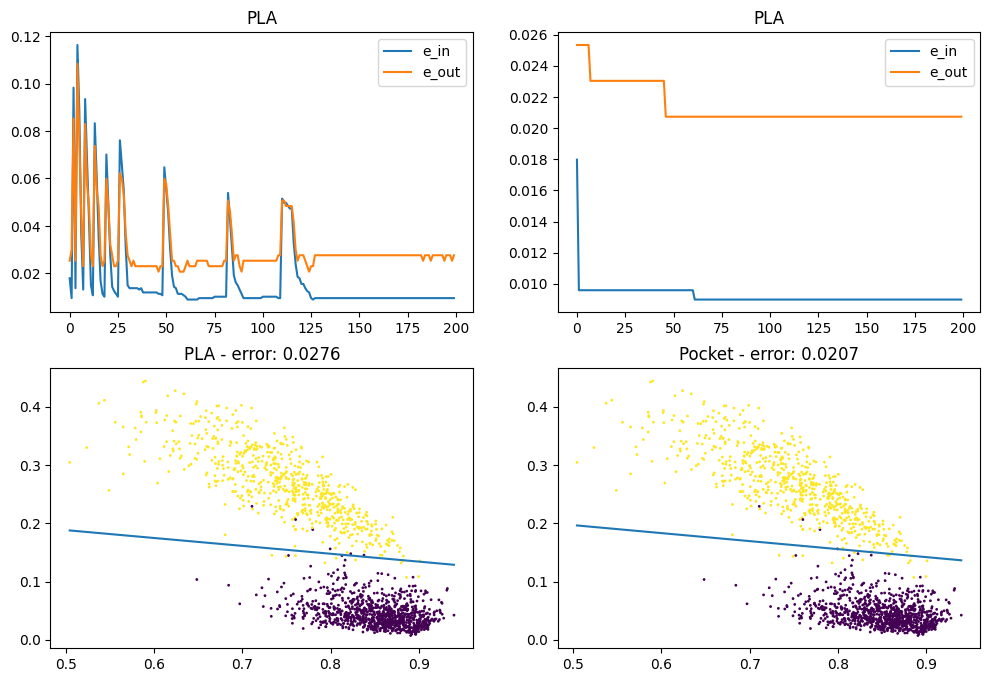

In [159]:
fig, axs = plt.subplots(2,2, figsize=(12, 8))
axs[0, 0].plot(e_in, label='e_in')
axs[0, 0].plot(e_out, label='e_out')
axs[0, 0].set_title(f'PLA')
axs[0, 0].legend()
axs[0, 1].plot(p_e_in, label='e_in')
axs[0, 1].plot(p_e_out, label='e_out')
axs[0, 1].set_title(f'PLA')
axs[0, 1].legend()

axs[1, 0].scatter(training_features[:, 0], training_features[:, 1], s=1, c=training_labels)
axs[1, 0].plot(x_range, pla_line)
axs[1, 0].set_title(f'PLA - error: {e_out[-1]:.4f}')
axs[1, 1].scatter(training_features[:, 0], training_features[:, 1], s=1, c=training_labels)
axs[1, 1].plot(x_range, pocket_line)
axs[1, 1].set_title(f'Pocket - error: {p_e_out[-1]:.4f}')
plt.show()

In [190]:
training_features, training_labels = get_features_labels(training_data, udid_digit, other_digit, third_feat=True)
testing_features, testing_labels = get_features_labels(testing_data, udid_digit, other_digit, third_feat=True)

print('training_features.shape', training_features.shape)
print('training_labels.shape', training_labels.shape, '\n')

print('testing_features.shape', testing_features.shape)
print('testing_labels.shape', testing_labels.shape)

training_features.shape (1669, 3)
training_labels.shape (1669,) 

testing_features.shape (434, 3)
testing_labels.shape (434,)


In [191]:
w, e_in, e_out, p_w, p_e_in, p_e_out = perceptron_learning_algorithm(training_features, training_labels, testing_features, testing_labels)

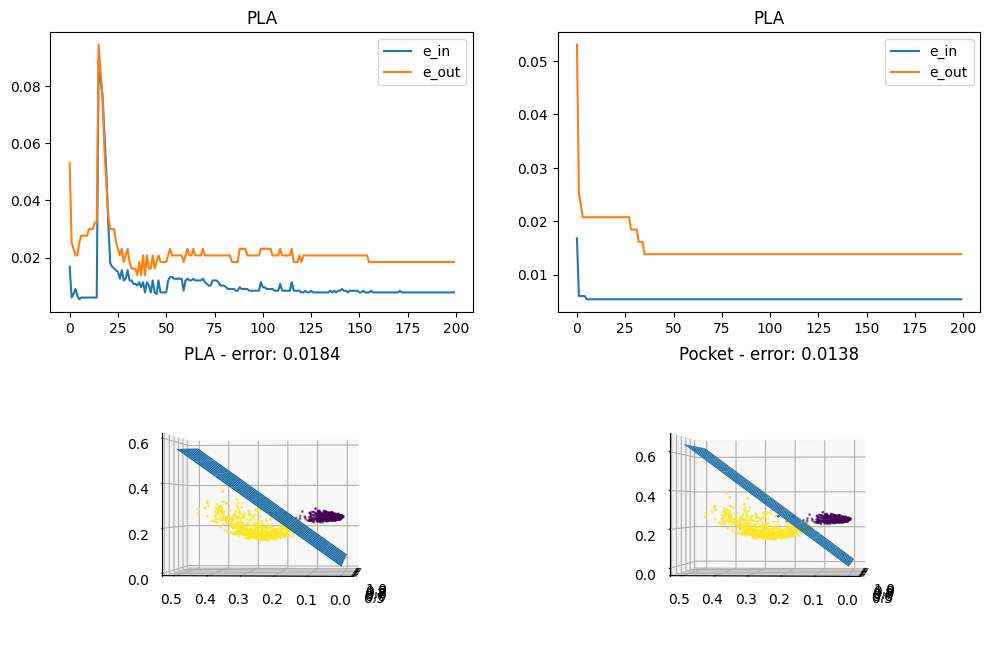

In [207]:
fig = plt.figure(figsize=(12, 8))
# 2D plots
axs = np.array([[plt.subplot(221), plt.subplot(222)],
                [plt.subplot(223, projection='3d'), plt.subplot(224, projection='3d')]])

axs[0, 0].plot(e_in, label='e_in')
axs[0, 0].plot(e_out, label='e_out')
axs[0, 0].set_title(f'PLA')
axs[0, 0].legend()
axs[0, 1].plot(p_e_in, label='e_in')
axs[0, 1].plot(p_e_out, label='e_out')
axs[0, 1].set_title(f'PLA')
axs[0, 1].legend()


a, b, c, d = w[1], w[2], w[3], -w[0]
p_a, p_b, p_c, p_d = p_w[1], p_w[2], p_w[3], -p_w[0]

x = np.linspace(0.5,1,10)
y = np.linspace(0,0.5,10)

X,Y = np.meshgrid(x,y)

pla_plane = (d - a*X - b*Y) / c
pocket_plane = (p_d - p_a*X - p_b*Y) / p_c

axs[1, 0].scatter(training_features[:, 0], training_features[:, 1], training_features[:, 2], s=1.2, c=training_labels)
axs[1, 0].view_init(elev=0., azim=-175)
axs[1, 0].plot_surface(X, Y, pla_plane)
axs[1, 0].set_title(f'PLA - error: {e_out[-1]:.4f}')
axs[1, 1].scatter(training_features[:, 0], training_features[:, 1], training_features[:, 2], s=1.2, c=training_labels)
axs[1, 1].view_init(elev=0., azim=-175)
axs[1, 1].plot_surface(X, Y, pocket_plane)
axs[1, 1].set_title(f'Pocket - error: {p_e_out[-1]:.4f}')
plt.show()